# Example 2: Reproducing Receiver Functions for Dipping and Anisotropic Subsurface Structure

In this example we generate *P* receiver functions for a model that includes either a dipping lower crustal layer or a lower-crustal anisotropic layer. These example reproduce the results of Figure 3 in [Porter et al. (2011)](#references).

Start by importing the necessary packages:

In [1]:
from pyraysum import prs, Geometry, Model, RC
import numpy as np

## Dipping Layers
Define the arrays of slowness and back-azimuth values of the incident `P` wave to use as input in the simulation

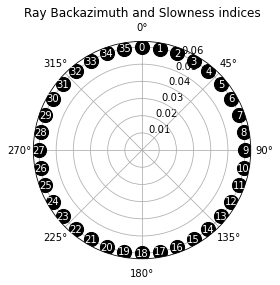

In [2]:
baz = np.arange(0., 360., 10.)
slow = 0.06
geom = Geometry(baz, slow)
_ = geom.plot()

Define the model object. The values used are found in the caption of Figure 3. Note that $V_S$ can be parameterized either directly or as $V_P/V_S$, which is what we do here. Also note that values that are constant for all layers can be given as floats. 

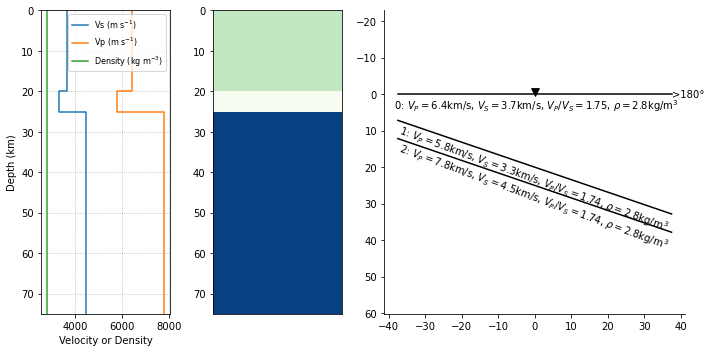

# thickn     rho      vp      vs  flag aniso   trend plunge strike   dip
 20000.0  2800.0  6400.0  3657.1    1    0.0     0.0    0.0   90.0   0.0
  5000.0  2800.0  5800.0  3333.3    1    0.0     0.0    0.0   90.0  20.0
     0.0  2800.0  7800.0  4482.8    1    0.0     0.0    0.0   90.0  20.0



In [3]:
thickn = [20000, 5000, 0]
rho = 2800
vp = [6400, 5800, 7800]
vpvs = [1.75, 1.74, 1.74]
dip = [0, 20, 20]
strike = 90

model = Model(thickn, rho, vp, vpvs=vpvs, strike=strike, dip=dip)
model.plot()
print(model)

Here we specify the argument `rot=1` to produce seismograms aligned in the `R-T-Z` coordinate system. The default value is `rot=0`, which produces seismograms aligned in the `N-E-Z` coordinate system that ***should not*** be used to calculate receiver functions. Furthermore, we are interested only in the direct conversions, and therefore specify `mults=0` to avoid dealing with multiples. This is required to reproduce the published examples, although it is good practice to keep all first-order multiples to properly simulate all possible phase arrivals.

In [4]:
rc = RC(rot=1, mults=0, verbose=False, npts=600, dt=0.0125)

Now, let's run the simulation. All book-keeping is handled internally.

In [5]:
seismogram = prs.run(model, geom, rc)

The function returns a `Seismogram` object whose attributes are the `Model`, `Geometry` of incoming rays, a list of `Streams` as well as all run-time arguments that are used by Raysum:

In [6]:
seismogram.__dict__.keys()

dict_keys(['model', 'geom', 'streams', 'rc'])

We can then use the method `calculate_rfs()` to calculate receiver functions.

In [7]:
seismogram.calculate_rfs()

The receiver functions are stored as an additional attribute of the streamlist object, which is itself a list of `Streams` containing the radial and transverse component RFs:

In [8]:
seismogram.__dict__.keys()

dict_keys(['model', 'geom', 'streams', 'rc', 'rfs'])

We can now filter and plot the results - we specify the key `'rfs'` to work on the receiver functions only. 

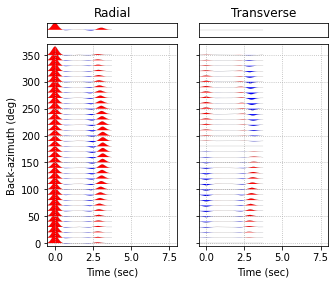

In [9]:
seismogram.filter('rfs', 'lowpass', freq=1., zerophase=True, corners=2)
seismogram.plot('rfs', tmin=-0.5, tmax=8.)

## Anisotropic Layers
Now let's reproduce the second case with the anisotropic lower crustal layer. Here, the second layer (`1` in python indexing) is not dipping, but has a strong anisotropy of -20%. The anisotropy axis trends south (`trend = 180`) and plunges 45 degree (`plunge = 45`). The *P*-wave velocity is 6.2 km/s. We could define a new model as above. Another possibility is to use use a short command string to change the existing model.

Note that when we change the *P* wave velocity and want to maintain a constant $V_P/V_S$ ratio, we must explicitly change `vpvs` by changing `vs`. This is archived using the `'pss'` attribute indicator below.

Changed: dip[1] = 0.0
Changed: dip[2] = 0.0
Changed: vp[1] = 6200.0
Changed: vpvs[1] = 1.75
Changed: ani[1] = -20.0
Changed: trend[1] = 180.0
Changed: plunge[1] = 45.0


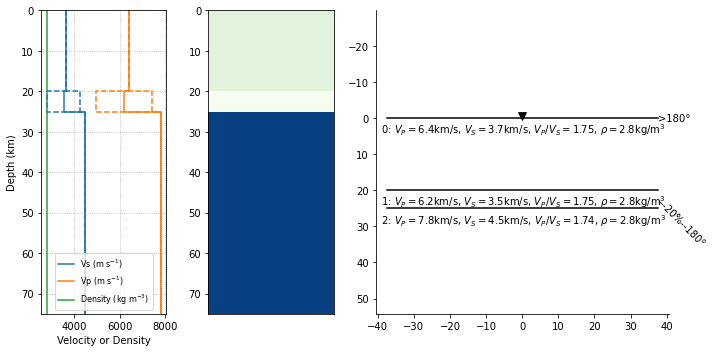

# thickn     rho      vp      vs  flag aniso   trend plunge strike   dip
 20000.0  2800.0  6400.0  3657.1    1    0.0     0.0    0.0   90.0   0.0
  5000.0  2800.0  6200.0  3542.9    0  -20.0   180.0   45.0   90.0   0.0
     0.0  2800.0  7800.0  4482.8    1    0.0     0.0    0.0   90.0   0.0



In [10]:
model.change('d1=0; d2=0; vp1=6.2; pss1=1.75; a1=-20; tr1=180; pl1=45;')
model.plot()
print(model)

Instead of two dipping interfaces, the model now has a thin anisotropic layer at the base of the crust. We again compute synthetic seismograms and use the `rf` argument to process the receiver functions as well.

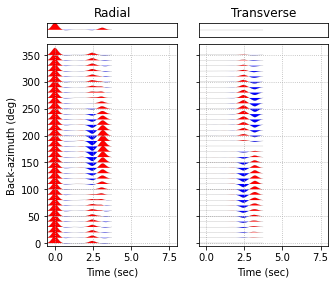

In [11]:
seismogram = prs.run(model, geom, rc, rf=True)

seismogram.filter('rfs', 'lowpass', freq=1., zerophase=True, corners=2)
seismogram.plot('rfs', tmin=-0.5, tmax=8.)

## Understanding Fast and Slow S-Waves
To understand the different phases present we can look at, e.g., the receiver function at back-azimuth 150°. We look into how the individual phases are called and when they arrive.

The following command tells us that the negative wiggle arriving at 2.5 seconds is a P-to-S conversion at the bottom of layer 0 (i.e. the top of the anisotropic layer), whereas the positive wiggle at 3s consists of two S-waves arriving shortly after one another: The smaller wiggle is the P-to-S1 conversion at the bottom of layer 1 (the anisotropic layer), and the larger one is the P-to-S2 conversion at the same interface. (Note that the slow S-wave is denoted *T*, to avoid ambiguity with the layer indices.) Both phases travel as an S-wave (here again named *T*) in the topmost layer 0, but at different speeds.

['2P1P0P' '2P1P0S' '2P1S0S' '2P1T0S']
[0.01250004768371582 2.4625535011291504 3.0867090225219727
 3.174315929412842]


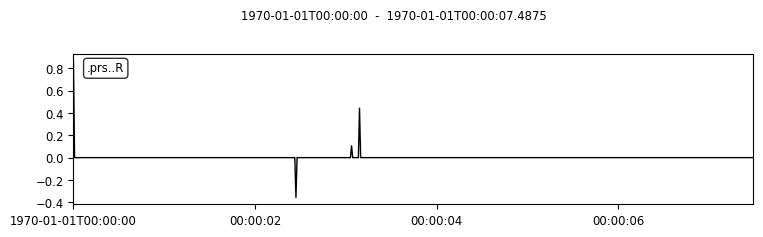

In [12]:
print(seismogram.streams[15][0].stats.phase_descriptors)
print(seismogram.streams[15][0].stats.phase_times)
_ = seismogram.streams[15][0].plot()

On the transverse component, the P-to-S1 conversion has a negative amplitude, while the P-to-S2 conversion has a larger, positive one.

['2P1P0T' '2P1S0T' '2P1T0T']
[2.4625535011291504 3.0867090225219727 3.174315929412842]


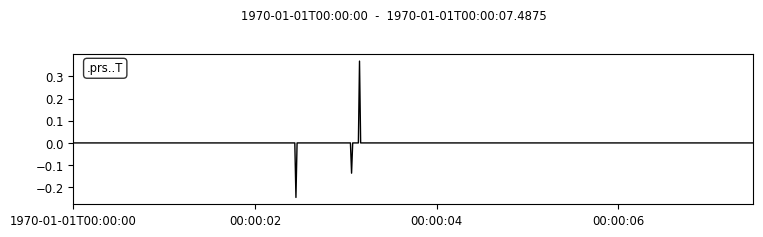

In [13]:
print(seismogram.streams[15][1].stats.phase_descriptors)
print(seismogram.streams[15][1].stats.phase_times)

_ = seismogram.streams[15][1].plot()

## Validation against Telewavesim Data
As in the previous example, we would now like to compare these results with independently obtained results from *Telewavesim*. We'll need *NumPy* to conveniently load our Telewavesim data from file, *obspy* to store them in a *Stream* object, and *Matplotlib* to make the comparison plot.

In [14]:
import obspy
import matplotlib.pyplot as mp

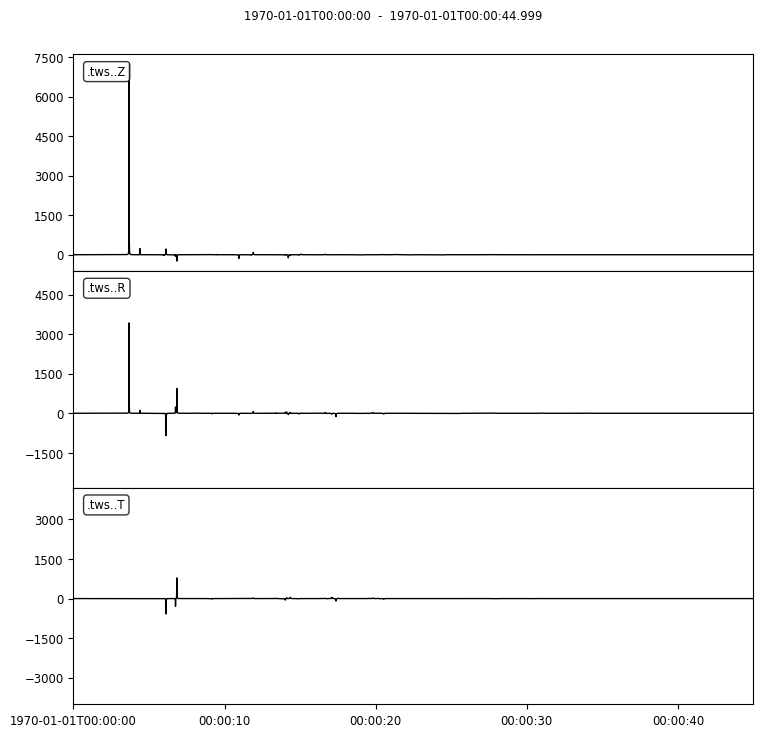

In [15]:
# Load telewavesim data
time, twr, twt, twz = np.loadtxt("../data/telewavesim_aniso_baz150-slow006.dat", unpack=True)

# Get time interval `dt` from data
dt = time[1] - time[0]

# Store into Stream, switch Z component polarity and set header
twsd = obspy.Stream()
for tr, channel in zip([twr, twt, twz], ["R", "T", "Z"]):
    header = {"delta": dt, "station": "tws", "channel": channel}
    trace = obspy.Trace(tr, header=header)
    twsd.append(trace)
    
# Make simple plot
_ = twsd.plot()

We'll again filter both seismograms, as Telewavesim data does not provide a good infinite frequency approximation.

In [16]:
# Set frequency corners in Hz
fmin = 1./10. 
fmax = 10
prsd = seismogram.streams[15]
prsd.trim(endtime = prsd[0].stats.starttime+5)

# Demean and filter all data
for dat in [twsd, prsd]:
    dat.detrend("demean")
    dat.filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True)


We also need to align the two different datasets to the direct *P*-wave and scale them to its amplitude on the vertical component.

In [17]:
# Index of the maximum amplitude on the vertical component of the data
imax = np.argmax(abs(prsd[2].data))

# Cycle through both synthetic data and process them equally
jmax = np.argmax(abs(twsd[2].data))  # maximum vertical amplitude
dt = prsd[2].times()[imax] - twsd[2].times()[jmax] # relative time shift of maximum
norm = prsd[2].data[imax] / twsd[2].data[jmax]  # relative amplitude of vertical maximum
for tr in twsd:
    tr.stats.starttime += dt  # align peaks
    tr.data *= norm  # normalize
    tr.trim(prsd[0].stats.starttime, prsd[0].stats.endtime)

For a good comparison, we use the plot function from the previous example:

In [18]:
def plot(data, model):
    
    lws = [4, 1]  # linewidths ...
    cols = ["darkgray", "crimson"]  # colors for data and model

    # Subplot with 3 rows
    fig, axs = mp.subplots(
        nrows=3, ncols=1, figsize=(8, 6), tight_layout=True, sharex=True, sharey=True
    )
    
    # Cycle through components
    for ax, dat, mod in zip(axs, data, model):
        trs = [dat, mod]
        
        # Cycle through data and model
        for tr, lw, col in zip(trs, lws, cols):
            ax.plot(
                tr.times(reftime=data[0].stats.starttime),
                tr.data,
                label=tr.stats.station + "." + tr.stats.channel,
                lw=lw,
                color=col,
            )
            # Write phase info
            if tr.stats.station == "prs":
                dy = 0.05
                # Cycle through phase descriptors
                for n, (pht, phn, pha) in enumerate(
                    zip(
                        tr.stats.phase_times,
                        tr.stats.phase_names,
                        tr.stats.phase_amplitudes,
                    )
                ):
                    ha = "center"
                    if phn == "PST":
                        ha = "right"
                    elif  phn == "PTS":
                        ha = "left"

                    sign = -np.sign(pha)  # absolute amplitudes are here meaningless due to applied filter
                    ax.text(pht, sign*dy, phn, va="center", ha=ha)

        ax.legend(frameon=False)
        ax.set_axis_off()
        
    # Only plot lowermost time axes
    ax.set_axis_on()
    ax.spines[["top", "left", "right", "bottom"]].set_visible(False)
    ax.set_yticks([])
    ax.set_xlabel("Time(s)")

    return fig

And run it

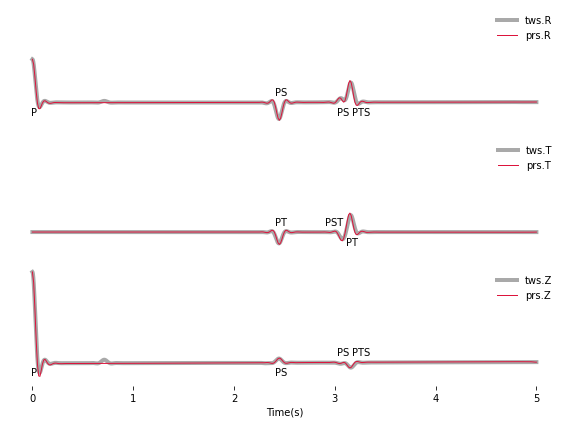

In [19]:
_ = plot(twsd, prsd)

We see that the Waveforms of *Pyraysum* (red) and *Teleweavesim* (gray) match pretty well. The *Telewavsim* data has some additional energy at about 0.9 seconds, which is a reflection from the top of the anisotropic layer. This reflections has explicitly not been computed (`RC.mults = 0`), but could using `RC.set_phaselist()`.

## Conclusion
In this example we have explored the capabilities of *Pyraysum* to compute synthetic seismograms and receiver functions for dipping or anisotropic layers. We have compared the outcome of our simulations with published results and, for the anisotropic example, also with synthetic data from another numerical method. Both comparisons showed that *Pyraysum* delivers comparable results.

## References
* Audet, P., Thomson, C.J., Bostock, M.G., and Eulenfeld, T. (2019). Telewavesim: Python software for teleseismic body wave modeling. Journal of Open Source Software, 4(44), 1818, https://doi.org/10.21105/joss.01818

* Porter, R., Zandt, G., & McQuarrie, N. (2011). Pervasive lower-crustal seismic anisotropy in Southern California: Evidence for underplated schists and active tectonics. Lithosphere, 3(3), 201-220. https://doi.org/10.1130/L126.1

* Thomson, C.J. (1997). Modelling surface waves in anisotropic structures: I. Theory. Physics of the Earth and Planetary interiors, 103, 195-206. https://doi.org/10.1016/S0031-9201(97)00033-2